In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import sys
import numpy as np
import glob
import torch

sys.path.insert(1,"/home/showalte/research/prob_seq_queries/")
from seq_queries.utils import read_pkl, write_pkl

In [26]:
h,s=16,20
dataset = 'apps'
def temp_ablation_plot(dataset, h, s,
    temps = [0.5, 0.75, 1,1.25,1.75,2,3,4,5,10],):
    gt = f"../data/pseudo_gt/{dataset}/val_dl/val-dl_{dataset}_pseudo-gt_{h}h_{s}s_1000mc_pgt_100q.pkl"
    gt_data = read_pkl(gt)
    excluded_terms = gt_data['excluded_terms']
    sub_est = [10,100,1000]
    gt_est = torch.gather(gt_data['sample_estimates'],1,excluded_terms.unsqueeze(0)).squeeze()
    # print(f"../data/temperature_ablation/{dataset}/val_dl/val-dl_{dataset}_temperature_ablation_*model-budget-bs*.pkl")
    # print(f"../data/temperature_ablation/{dataset}/val_dl/temp_pgt/val-dl_{dataset}_pseudo-gt*.pkl")
    pgt_paths = sorted(glob.glob(f"../data/temperature_ablation/{dataset}/val_dl/temp_pgt/val-dl_{dataset}_pseudo-gt*.pkl"),
                      key = lambda pth: float(pth.split("_")[-3].replace('t','')))
    bs_paths = sorted(glob.glob(f"../data/temperature_ablation/{dataset}/val_dl/val-dl_{dataset}_temperature-ablation_*model-budget-bs*.pkl"),
                      key = lambda pth: float(pth.split("_")[-4].replace('t','')))
    is_paths = sorted(glob.glob(f"../data/temperature_ablation/{dataset}/val_dl/val-dl_{dataset}_temperature-ablation_*model-budget-imp-samp*.pkl"),
                      key = lambda pth: float(pth.split("_")[-4].replace('t','')))
    # print(is_paths)
    # asdf
    # print(pgt_paths)

    errors_list = []
    for pgt_path,bs_path,is_path,temp in zip(pgt_paths,bs_paths,is_paths,temps):
        pgt_data = read_pkl(pgt_path)
        bs_data = read_pkl(bs_path)
        is_data = read_pkl(is_path)
        pgt_est = torch.gather(pgt_data['sample_estimates'],1,pgt_data['excluded_terms'].unsqueeze(0)).squeeze()
        is_samples = torch.gather(is_data['sample_estimates'][:,-1,:],1,is_data['excluded_terms'].unsqueeze(0)).squeeze()
        bs_samples = torch.gather(bs_data['bs_lower_bound'][:,-1,:],1,bs_data['excluded_terms'].unsqueeze(0)).squeeze()
        # print(is_samples.shape)
        # print(gt_est.shape)
        # print((is_samples == 0).sum()/is_samples.shape[0])
        # print(pgt_est[0], bs_samples[1], is_samples[1])
        bs_errors = torch.abs(pgt_est - bs_samples)/(pgt_est)
        is_errors = torch.abs(pgt_est - is_samples)/(pgt_est)
        # print((bs_errors == 1).sum())
        errors_list.append((bs_errors,is_errors))
    
    dfs = []
    for (bs,imp),t in zip(errors_list,temps):
        bs_data = pd.DataFrame(bs.numpy(),columns=['error'])
        bs_data['est_type'] = 'beam_search'
        is_data = pd.DataFrame(imp.numpy(),columns=['error'])
        is_data['est_type'] = 'importance_sampling'

        df = pd.concat([bs_data,is_data],axis=0)
        df['temperature'] = t
        dfs.append(df)
    df['error'] = np.log(df['error'] + 1e-10)
    df=pd.concat(dfs,axis=0)
    return df,temps

In [28]:
df,temps = temp_ablation_plot('amazon',11,15)
df.shape

RuntimeError: The size of tensor a (1000) must match the size of tensor b (100) at non-singleton dimension 0

In [16]:
df.columns
# df.error = np.log(df.error+ 1e-10)

Index(['error', 'est_type', 'temperature'], dtype='object')

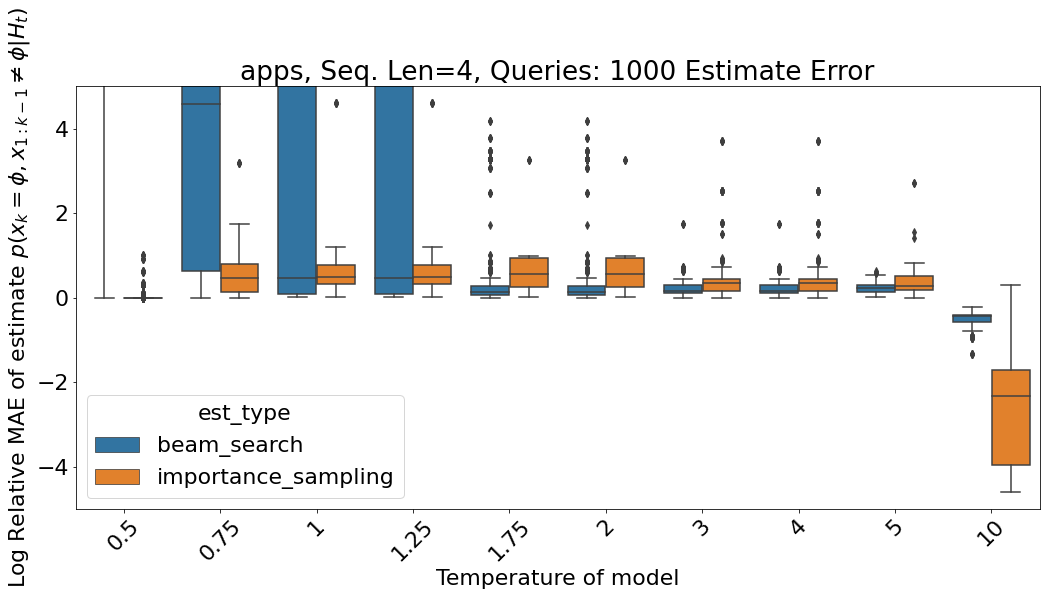

In [23]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
fig,ax = plt.subplots(figsize=(15,8))
sns.boxplot(x='temperature', y='error',data=df,hue='est_type')
ax.set_xticklabels(temps)
plt.xlabel("Temperature of model")
plt.ylabel(r"Log Relative MAE of estimate $p(x_k = \phi, x_{1:k-1} \neq \phi|H_t)$")
plt.title(f"{dataset}, Seq. Len={s-h}, Queries: 1000 Estimate Error")
plt.xticks(rotation=45)
plt.ylim(-5,5)
plt.tight_layout()